In [1]:
%matplotlib widget

In [2]:
# TODO: add new thickness logic to all plots
# make backwards angle plots
# make slides including plots and legends (maybe gifs, but they don't look very good, has weird flashing of colors?)

In [3]:
import xgboost as xgb
import matplotlib as mpl
import matplotlib.pyplot as plt
#import uproot3 as uproot
import uproot

import pandas as pd
import numpy as np
import math
from tqdm import tqdm

import pickle

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from IPython.display import display

# should be xgboost v1.3.0, needs to be old in order to calculate the score correctly!
# uproot can be any version 3 I think
print(xgb.__version__)
print(uproot.__version__)

1.3.0
4.3.4


In [4]:
backwards = False

In [5]:
f = uproot.open("numuCC_3D_data/ana_3d.root")
for k in f.keys():
    print(k)


qe_nuwro_smear;1
mec_nuwro_smear;1
spi_nuwro_smear;1
other_nuwro_smear;1
tot_nuwro_smear;1
mc_stack_nuwro_smear;1
qe_nuwro_smear_2d;1
mec_nuwro_smear_2d;1
spi_nuwro_smear_2d;1
other_nuwro_smear_2d;1
tot_nuwro_smear_2d;1
mc_stack_nuwro_smear_2d;1
integrated_mc_nuwro_smear;1
integrated_data;4
integrated_data;3
integrated_data;2
integrated_data;1
data;4
data;3
data;2
data;1
data_2d;4
data_2d;3
data_2d;2
data_2d;1
qe_neut_smear;1
mec_neut_smear;1
spi_neut_smear;1
other_neut_smear;1
tot_neut_smear;1
mc_stack_neut_smear;1
qe_neut_smear_2d;1
mec_neut_smear_2d;1
spi_neut_smear_2d;1
other_neut_smear_2d;1
tot_neut_smear_2d;1
mc_stack_neut_smear_2d;1
integrated_mc_neut_smear;1
qe_genie3_smear;1
mec_genie3_smear;1
spi_genie3_smear;1
other_genie3_smear;1
tot_genie3_smear;1
mc_stack_genie3_smear;1
qe_genie3_smear_2d;1
mec_genie3_smear_2d;1
spi_genie3_smear_2d;1
other_genie3_smear_2d;1
tot_genie3_smear_2d;1
mc_stack_genie3_smear_2d;1
integrated_mc_genie3_smear;1
qe_genie2_smear;1
mec_genie2_smear;1
s

In [6]:
data_3d = f["data"].values()
data_3d_err = f["data"].errors()

mc_3d = f["tot_tuned_smear"].values()
nuwro_3d = f["tot_nuwro_smear"].values()
neut_3d = f["tot_neut_smear"].values()
genie_v3_3d = f["tot_genie3_smear"].values()
genie_v2_3d = f["tot_genie2_smear"].values()


In [7]:
print(len(mc_3d), len(nuwro_3d), len(neut_3d), len(genie_v3_3d), len(genie_v2_3d))

138 138 138 138 138


In [8]:
energy_bin_edges = [0.2, 0.705, 1.05, 1.57, 4.0]
angle_bin_edges = [-1., -0.5, 0, 0.27, 0.45, 0.62, 0.76, 0.86, 0.94, 1.]

In [9]:
with open("numuCC_3D_data/xs_real_bin.txt") as f_bins:
    lines = f_bins.readlines()

In [10]:
relevant_strings = [line.split("\t")[3] for line in lines]
energy_bin_strs = [s.split(".")[2] for s in relevant_strings]
angle_bin_strs = [s.split(".")[3] for s in relevant_strings]
momentum_bin_lower_edges = [int(s.split(".")[8]) / 1000. for s in relevant_strings]
momentum_bin_upper_edges = [int(s.split(".")[6]) / 1000. for s in relevant_strings]
relevant_strings[0]

'numuCC.inside.Enu0.theta0.Pmuon.le.180.gt.0'

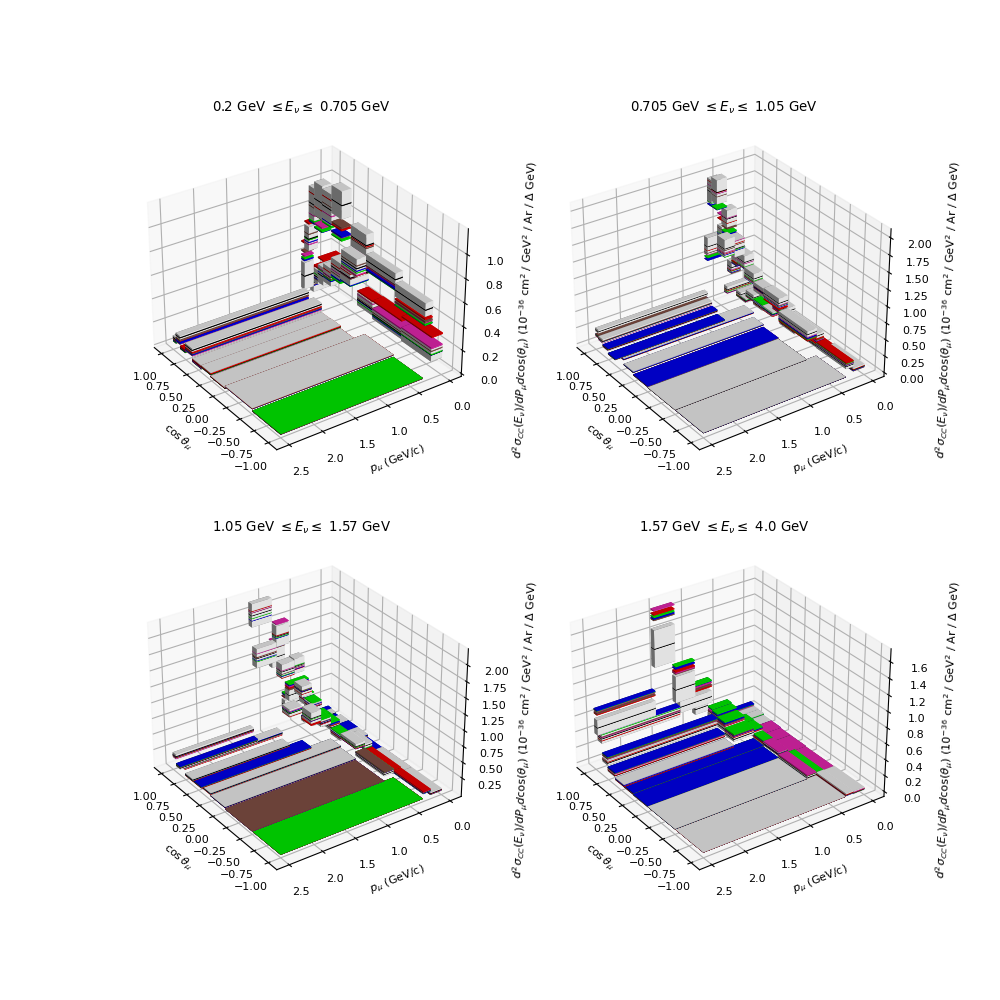

In [11]:
include_mc = True
include_nuwro = True
include_neut = True
include_genie_v3 = True
include_genie_v2 = True


theta = []
mom = []
z = []
dtheta = []
dmom = []
dz = []
z_mc = []
dz_mc = []
z_nuwro = []
dz_nuwro = []
z_neut = []
dz_neut = []
z_genie_v3 = []
dz_genie_v3 = []
z_genie_v2 = []
dz_genie_v2 = []
z_err = []
dz_err = []


for i in range(138):
    
    z_err.append([])
    dz_err.append([])
    
    gap = 0.0001
    
    for k in range(9):
        if angle_bin_strs[i] == f"theta{k}":
            theta.append(angle_bin_edges[k])
            dtheta.append(angle_bin_edges[k+1] - angle_bin_edges[k] - gap)
    
    mom.append(momentum_bin_lower_edges[i])
    dmom.append(momentum_bin_upper_edges[i] - momentum_bin_lower_edges[i] - gap)
    
    
    # this section includes all blocks that will be plotted, including data cv, MC predictions, and data errors (possibly split by other predictions)
    
    lower_err = (data_3d[i] - data_3d_err[i])
    upper_err = (data_3d[i] + data_3d_err[i])
    
    thickness = min(0.01, (upper_err - lower_err) / 2.)
    
    z.append(data_3d[i] - thickness / 2.)
    dz.append(thickness - gap)
    
    z_mc.append(mc_3d[i] - thickness / 2.)
    dz_mc.append(thickness - gap)
    
    z_nuwro.append(nuwro_3d[i] - thickness / 2.)
    dz_nuwro.append(thickness - gap)
    
    z_neut.append(neut_3d[i] - thickness / 2.)
    dz_neut.append(thickness - gap)

    z_genie_v3.append(genie_v3_3d[i] - thickness / 2.)
    dz_genie_v3.append(thickness - gap)
 
    z_genie_v2.append(genie_v2_3d[i] - thickness / 2.)
    dz_genie_v2.append(thickness - gap)
    
    interrupting_vals = []
    interrupting_vals.append(data_3d[i])
    if include_mc:
        interrupting_vals.append(mc_3d[i])
    if include_nuwro:
        interrupting_vals.append(nuwro_3d[i])
    if include_neut:
        interrupting_vals.append(neut_3d[i])
    if include_genie_v3:
        interrupting_vals.append(genie_v3_3d[i])
    if include_genie_v2:
        interrupting_vals.append(genie_v2_3d[i])
    
    interrupting_vals.sort()
    
    z_err_edges = []
    z_err_edges.append(lower_err)
    for v in interrupting_vals:
        if lower_err < v < upper_err:
            z_err_edges.append(v)
    z_err_edges.append(upper_err)
    
    fixed_z_err_edges = [z_err_edges[0]]
        
    for k in range(len(z_err_edges) - 1):
                
        if k == 0 or k == len(z_err_edges) - 2:
            width = z_err_edges[k+1] - z_err_edges[k] - thickness / 2. - gap
        else:
            width = z_err_edges[k+1] - z_err_edges[k] - thickness - gap

        if width > 0:
            if z_err_edges[k] in interrupting_vals:
                z_err[-1].append(z_err_edges[k] + thickness / 2.)
            else:
                z_err[-1].append(z_err_edges[k])
            dz_err[-1].append(width)
            fixed_z_err_edges.append(z_err_edges[k+1])
            
            
    if i == -1:
        print("data with err", data_3d[i] - data_3d_err[i], data_3d[i], data_3d[i] + data_3d_err[i])
        print("mc pred", mc_3d[i])
        print("interrupting vals", interrupting_vals)
        print("z edges with small sections removed", fixed_z_err_edges)
        print("all z bases", z_err[-1])
        print("all z widths", dz_err[-1])


mpl.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(10,10))
    
for e_i in [0, 1, 2, 3]:
    if e_i == 0:
        low = 0
        high = 28
        title = r"0.2 GeV $\leq E_\nu \leq$ 0.705 GeV"
    elif e_i == 1:
        low = 28
        high = 63
        title = r"0.705 GeV $\leq E_\nu \leq$ 1.05 GeV"
    elif e_i == 2:
        low = 63
        high = 105
        title = r"1.05 GeV $\leq E_\nu \leq$ 1.57 GeV"
    elif e_i == 3:
        low = 105
        high = 138
        title = r"1.57 GeV $\leq E_\nu \leq$ 4.0 GeV"
    
    theta_e = theta[low:high]
    dtheta_e = dtheta[low:high]
    mom_e = mom[low:high]
    dmom_e = dmom[low:high]
    z_e = z[low:high]
    dz_e = dz[low:high]
    z_err_e = z_err[low:high]
    dz_err_e = dz_err[low:high]
    
    z_mc_e = z_mc[low:high]
    dz_mc_e = dz_mc[low:high]
    z_nuwro_e = z_nuwro[low:high]
    dz_nuwro_e = dz_nuwro[low:high]
    z_neut_e = z_neut[low:high]
    dz_neut_e = dz_neut[low:high]
    z_genie_v3_e = z_genie_v3[low:high]
    dz_genie_v3_e = dz_genie_v3[low:high]
    z_genie_v2_e = z_genie_v2[low:high]
    dz_genie_v2_e = dz_genie_v2[low:high]
    
    
    
    ax = fig.add_subplot(2, 2, e_i+1, projection='3d')
    
    if backwards:
        x1, y1, z1 = 2.5, -1., 10.
    else:
        ax.view_init(elev=30., azim=145.)
        x1, y1, z1 = -1., 2.5, 10.
        
    z_supression = 1e-8 # make the z position have less priority than x and y positions for occlusion
    distances_xy = []
    for i in range(len(theta_e)):
        distances_xy.append(-np.sqrt((theta_e[i] - x1)**2 + (mom_e[i] - y1)**2))
            
    for i in range(len(theta_e)):
        
        #print(e_i, i, z_e[i])
        
        #if e_i == 3 and i == 0:
        #    print(e_i, i, z_e[i], mom_e[i], dmom_e[i], theta_e[i], dtheta_e[i])
        
        # plotting data CV
        pl = ax.bar3d(theta_e[i], mom_e[i], z_e[i], dtheta_e[i], dmom_e[i], dz_e[i], color="k", label="MicroBooNE 6.369e20 POT Unfolded Data")
        pl._sort_zpos = distances_xy[i] + 1e-4 * z_e[i] # z distance is last priority
        
        if include_mc:
            pl = ax.bar3d(theta_e[i], mom_e[i], z_mc_e[i], dtheta_e[i], dmom_e[i], dz_mc_e[i], color="#f72abd", label="MicroBooNE GENIE Tune")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_mc_e[i]
            
        if include_nuwro:
            pl = ax.bar3d(theta_e[i], mom_e[i], z_nuwro_e[i], dtheta_e[i], dmom_e[i], dz_nuwro_e[i], color="tab:brown", label="Nuwro")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_nuwro_e[i]
            
        if include_neut:
            pl = ax.bar3d(theta_e[i], mom_e[i], z_neut_e[i], dtheta_e[i], dmom_e[i], dz_neut_e[i], color="b", label="Neut v5")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_neut_e[i]
            
        if include_neut:
            pl = ax.bar3d(theta_e[i], mom_e[i], z_genie_v3_e[i], dtheta_e[i], dmom_e[i], dz_genie_v3_e[i], color="lime", label="GENIE v3")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_genie_v3_e[i]
        
        if include_neut:
            pl = ax.bar3d(theta_e[i], mom_e[i], z_genie_v2_e[i], dtheta_e[i], dmom_e[i], dz_genie_v2_e[i], color="red", label="GENIE v2")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_genie_v2_e[i]
        
        # plotting data error
        for k in range(len(z_err_e[i])):
            pl = ax.bar3d(theta_e[i], mom_e[i], z_err_e[i][k], dtheta_e[i], dmom_e[i], dz_err_e[i][k], color="w")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_err_e[i][k]

    #ax.bar3d(theta_e, mom_e, z_err_bottom_e, dtheta_e, dmom_e, dz_err_bottom_e, zorder=1, alpha=err_alpha, color=err_color)
    #ax.bar3d(theta_e, mom_e, z_err_top_e, dtheta_e, dmom_e, dz_err_top_e, zorder=3, alpha=err_alpha, color=err_color)


    #ax.bar3d(theta_e, mom_e, z_err_bottom_e, dtheta_e, dmom_e, dz_err_bottom_e, zorder=zorders, alpha=err_alpha, color=err_color)
    #ax.bar3d(theta_e, mom_e, z_err_top_e, dtheta_e, dmom_e, dz_err_top_e, zorder=zorders, alpha=err_alpha, color=err_color)

    plt.title(title)

    ax.set_xlabel(r'$\cos \theta_\mu$')
    ax.set_ylabel(r'$p_\mu$ (GeV/c)')
    ax.set_zlabel(r'$d^2\sigma_{CC}(E_\nu)/dP_\mu d\cos(\theta_\mu)$ ($10^{-36}$ cm$^2$ / GeV$^2$ / Ar / $\Delta$ GeV)')

plt.show()
if backwards:
    plt.savefig("plots/data_and_all_pred_backwards.png", dpi=600)
else:
    plt.savefig("plots/data_and_all_pred.png", dpi=600)


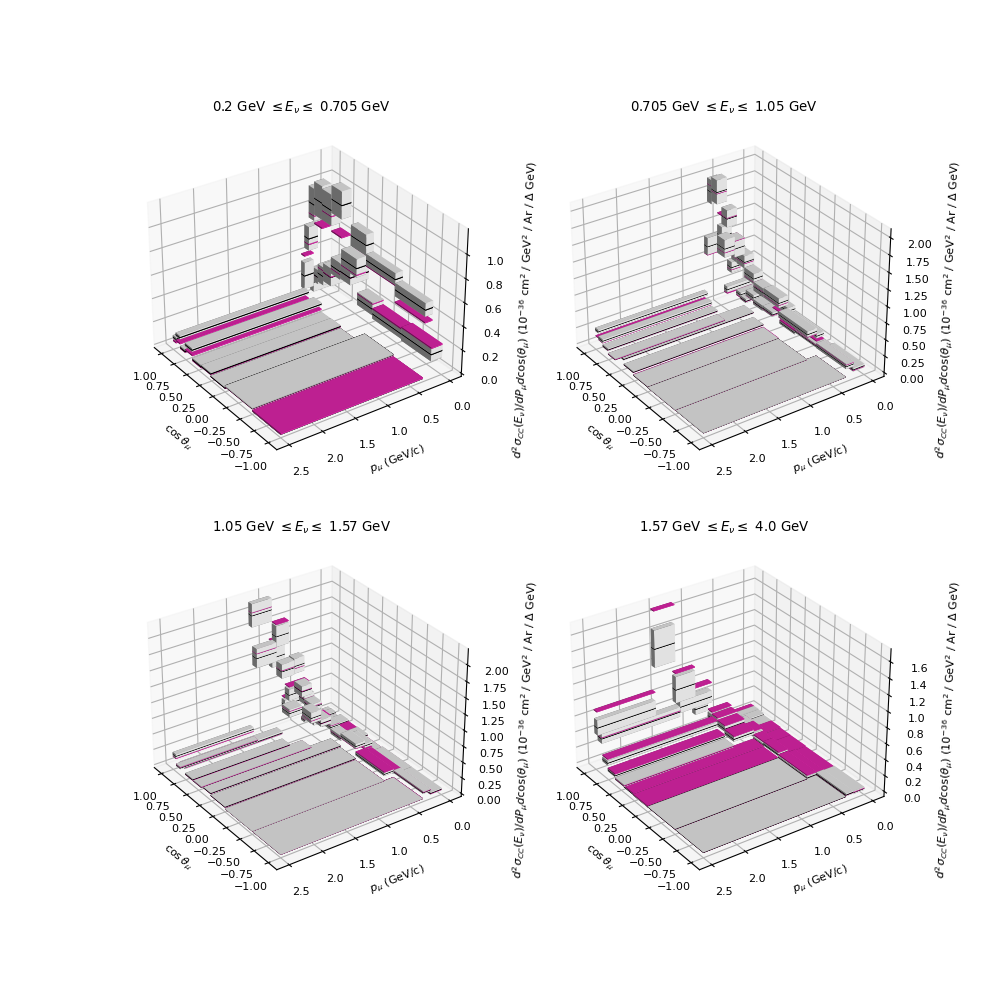

In [12]:
include_mc = True
include_nuwro = False
include_neut = False
include_genie_v3 = False
include_genie_v2 = False


theta = []
mom = []
z = []
dtheta = []
dmom = []
dz = []
z_mc = []
dz_mc = []
z_nuwro = []
dz_nuwro = []
z_neut = []
dz_neut = []
z_genie_v3 = []
dz_genie_v3 = []
z_genie_v2 = []
dz_genie_v2 = []
z_err = []
dz_err = []


for i in range(138):
    
    z_err.append([])
    dz_err.append([])
    
    gap = 0.0001
    
    for k in range(9):
        if angle_bin_strs[i] == f"theta{k}":
            theta.append(angle_bin_edges[k])
            dtheta.append(angle_bin_edges[k+1] - angle_bin_edges[k] - gap)
    
    mom.append(momentum_bin_lower_edges[i])
    dmom.append(momentum_bin_upper_edges[i] - momentum_bin_lower_edges[i] - gap)
    
    
    # this section includes all blocks that will be plotted, including data cv, MC predictions, and data errors (possibly split by other predictions)
    
    thickness = 0.01
    
    z.append(data_3d[i] - thickness / 2.)
    dz.append(thickness - gap)
    
    z_mc.append(mc_3d[i] - thickness / 2.)
    dz_mc.append(thickness - gap)
    
    z_nuwro.append(nuwro_3d[i] - thickness / 2.)
    dz_nuwro.append(thickness - gap)
    
    z_neut.append(neut_3d[i] - thickness / 2.)
    dz_neut.append(thickness - gap)

    z_genie_v3.append(genie_v3_3d[i] - thickness / 2.)
    dz_genie_v3.append(thickness - gap)
 
    z_genie_v2.append(genie_v2_3d[i] - thickness / 2.)
    dz_genie_v2.append(thickness - gap)
    
    interrupting_vals = []
    interrupting_vals.append(data_3d[i])
    if include_mc:
        interrupting_vals.append(mc_3d[i])
    if include_nuwro:
        interrupting_vals.append(nuwro_3d[i])
    if include_neut:
        interrupting_vals.append(neut_3d[i])
    if include_genie_v3:
        interrupting_vals.append(genie_v3_3d[i])
    if include_genie_v2:
        interrupting_vals.append(genie_v2_3d[i])
    
    interrupting_vals.sort()
    
    lower_err = data_3d[i] - data_3d_err[i]
    upper_err = data_3d[i] + data_3d_err[i]
    
    if upper_err - lower_err < thickness:
        thickness = (upper_err - lower_err) / 2.
    
    z_err_edges = []
    z_err_edges.append(lower_err)
    for v in interrupting_vals:
        if lower_err < v < upper_err:
            z_err_edges.append(v)
    z_err_edges.append(upper_err)
    
    fixed_z_err_edges = [z_err_edges[0]]
        
    for k in range(len(z_err_edges) - 1):
                
        if k == 0 or k == len(z_err_edges) - 2:
            width = z_err_edges[k+1] - z_err_edges[k] - thickness / 2. - gap
        else:
            width = z_err_edges[k+1] - z_err_edges[k] - thickness - gap

        if width > 0:
            if z_err_edges[k] in interrupting_vals:
                z_err[-1].append(z_err_edges[k] + thickness / 2.)
            else:
                z_err[-1].append(z_err_edges[k])
            dz_err[-1].append(width)
            fixed_z_err_edges.append(z_err_edges[k+1])
            
            
    if i == -1:
        print("data with err", data_3d[i] - data_3d_err[i], data_3d[i], data_3d[i] + data_3d_err[i])
        print("mc pred", mc_3d[i])
        print("interrupting vals", interrupting_vals)
        print("z edges with small sections removed", fixed_z_err_edges)
        print("all z bases", z_err[-1])
        print("all z widths", dz_err[-1])


mpl.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(10,10))
    
for e_i in [0, 1, 2, 3]:
    if e_i == 0:
        low = 0
        high = 28
        title = r"0.2 GeV $\leq E_\nu \leq$ 0.705 GeV"
    elif e_i == 1:
        low = 28
        high = 63
        title = r"0.705 GeV $\leq E_\nu \leq$ 1.05 GeV"
    elif e_i == 2:
        low = 63
        high = 105
        title = r"1.05 GeV $\leq E_\nu \leq$ 1.57 GeV"
    elif e_i == 3:
        low = 105
        high = 138
        title = r"1.57 GeV $\leq E_\nu \leq$ 4.0 GeV"
    
    theta_e = theta[low:high]
    dtheta_e = dtheta[low:high]
    mom_e = mom[low:high]
    dmom_e = dmom[low:high]
    z_e = z[low:high]
    dz_e = dz[low:high]
    z_err_e = z_err[low:high]
    dz_err_e = dz_err[low:high]
    
    z_mc_e = z_mc[low:high]
    dz_mc_e = dz_mc[low:high]
    z_nuwro_e = z_nuwro[low:high]
    dz_nuwro_e = dz_nuwro[low:high]
    z_neut_e = z_neut[low:high]
    dz_neut_e = dz_neut[low:high]
    z_genie_v3_e = z_genie_v3[low:high]
    dz_genie_v3_e = dz_genie_v3[low:high]
    z_genie_v2_e = z_genie_v2[low:high]
    dz_genie_v2_e = dz_genie_v2[low:high]
    
    
    
    ax = fig.add_subplot(2, 2, e_i+1, projection='3d')
    
    if backwards:
        x1, y1, z1 = 2.5, -1., 10.
    else:
        ax.view_init(elev=30., azim=145.)
        x1, y1, z1 = -1., 2.5, 10.
        
    z_supression = 1e-8 # make the z position have less priority than x and y positions for occlusion
    distances_xy = []
    for i in range(len(theta_e)):
        distances_xy.append(-np.sqrt((theta_e[i] - x1)**2 + (mom_e[i] - y1)**2))
            
    for i in range(len(theta_e)):
        
        #print(e_i, i, z_e[i])
        
        #if e_i == 3 and i == 0:
        #    print(e_i, i, z_e[i], mom_e[i], dmom_e[i], theta_e[i], dtheta_e[i])
        
        # plotting data CV
        pl = ax.bar3d(theta_e[i], mom_e[i], z_e[i], dtheta_e[i], dmom_e[i], dz_e[i], color="k", label="MicroBooNE 6.369e20 POT Unfolded Data")
        pl._sort_zpos = distances_xy[i] + 1e-4 * z_e[i] # z distance is last priority
        
        if include_mc:
            pl = ax.bar3d(theta_e[i], mom_e[i], z_mc_e[i], dtheta_e[i], dmom_e[i], dz_mc_e[i], color="#f72abd", label="MicroBooNE GENIE Tune")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_mc_e[i]
            
        if include_nuwro:
            pl = ax.bar3d(theta_e[i], mom_e[i], z_nuwro_e[i], dtheta_e[i], dmom_e[i], dz_nuwro_e[i], color="tab:brown", label="Nuwro")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_nuwro_e[i]
            
        if include_neut:
            pl = ax.bar3d(theta_e[i], mom_e[i], z_neut_e[i], dtheta_e[i], dmom_e[i], dz_neut_e[i], color="b", label="Neut v5")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_neut_e[i]
            
        if include_neut:
            pl = ax.bar3d(theta_e[i], mom_e[i], z_genie_v3_e[i], dtheta_e[i], dmom_e[i], dz_genie_v3_e[i], color="lime", label="GENIE v3")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_genie_v3_e[i]
        
        if include_neut:
            pl = ax.bar3d(theta_e[i], mom_e[i], z_genie_v2_e[i], dtheta_e[i], dmom_e[i], dz_genie_v2_e[i], color="red", label="GENIE v2")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_genie_v2_e[i]
        
        # plotting data error
        for k in range(len(z_err_e[i])):
            pl = ax.bar3d(theta_e[i], mom_e[i], z_err_e[i][k], dtheta_e[i], dmom_e[i], dz_err_e[i][k], color="w")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_err_e[i][k]

    #ax.bar3d(theta_e, mom_e, z_err_bottom_e, dtheta_e, dmom_e, dz_err_bottom_e, zorder=1, alpha=err_alpha, color=err_color)
    #ax.bar3d(theta_e, mom_e, z_err_top_e, dtheta_e, dmom_e, dz_err_top_e, zorder=3, alpha=err_alpha, color=err_color)


    #ax.bar3d(theta_e, mom_e, z_err_bottom_e, dtheta_e, dmom_e, dz_err_bottom_e, zorder=zorders, alpha=err_alpha, color=err_color)
    #ax.bar3d(theta_e, mom_e, z_err_top_e, dtheta_e, dmom_e, dz_err_top_e, zorder=zorders, alpha=err_alpha, color=err_color)

    plt.title(title)

    ax.set_xlabel(r'$\cos \theta_\mu$')
    ax.set_ylabel(r'$p_\mu$ (GeV/c)')
    ax.set_zlabel(r'$d^2\sigma_{CC}(E_\nu)/dP_\mu d\cos(\theta_\mu)$ ($10^{-36}$ cm$^2$ / GeV$^2$ / Ar / $\Delta$ GeV)')

plt.show()
if backwards:
    plt.savefig("plots/data_and_tune_pred_backwards.png", dpi=600)
else:
    plt.savefig("plots/data_and_tune_pred.png", dpi=600)



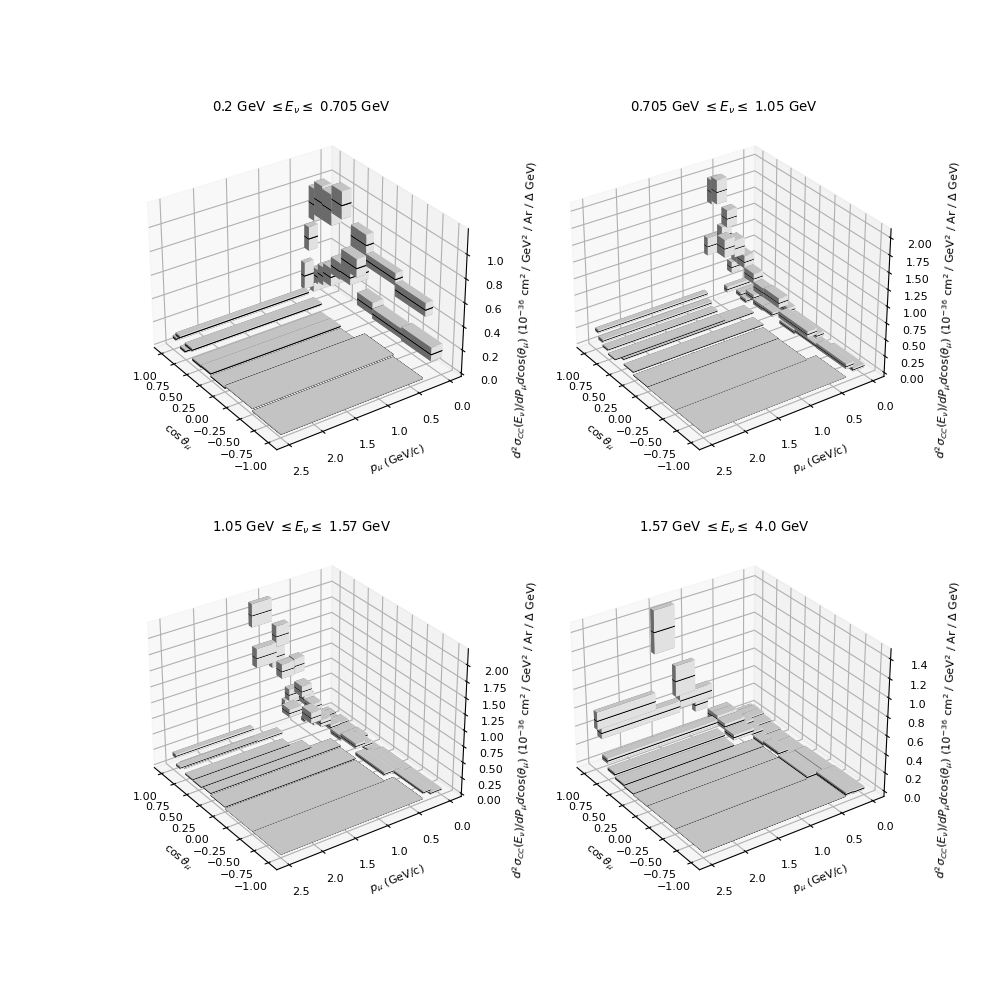

In [13]:
include_mc = False
include_nuwro = False
include_neut = False
include_genie_v3 = False
include_genie_v2 = False


theta = []
mom = []
z = []
dtheta = []
dmom = []
dz = []
z_mc = []
dz_mc = []
z_nuwro = []
dz_nuwro = []
z_neut = []
dz_neut = []
z_genie_v3 = []
dz_genie_v3 = []
z_genie_v2 = []
dz_genie_v2 = []
z_err = []
dz_err = []


for i in range(138):
    
    z_err.append([])
    dz_err.append([])
    
    gap = 0.0001
    
    for k in range(9):
        if angle_bin_strs[i] == f"theta{k}":
            theta.append(angle_bin_edges[k])
            dtheta.append(angle_bin_edges[k+1] - angle_bin_edges[k] - gap)
    
    mom.append(momentum_bin_lower_edges[i])
    dmom.append(momentum_bin_upper_edges[i] - momentum_bin_lower_edges[i] - gap)
    
    
    # this section includes all blocks that will be plotted, including data cv, MC predictions, and data errors (possibly split by other predictions)
    
    thickness = 0.01
    
    z.append(data_3d[i] - thickness / 2.)
    dz.append(thickness - gap)
    
    z_mc.append(mc_3d[i] - thickness / 2.)
    dz_mc.append(thickness - gap)
    
    z_nuwro.append(nuwro_3d[i] - thickness / 2.)
    dz_nuwro.append(thickness - gap)
    
    z_neut.append(neut_3d[i] - thickness / 2.)
    dz_neut.append(thickness - gap)

    z_genie_v3.append(genie_v3_3d[i] - thickness / 2.)
    dz_genie_v3.append(thickness - gap)
 
    z_genie_v2.append(genie_v2_3d[i] - thickness / 2.)
    dz_genie_v2.append(thickness - gap)
    
    interrupting_vals = []
    interrupting_vals.append(data_3d[i])
    if include_mc:
        interrupting_vals.append(mc_3d[i])
    if include_nuwro:
        interrupting_vals.append(nuwro_3d[i])
    if include_neut:
        interrupting_vals.append(neut_3d[i])
    if include_genie_v3:
        interrupting_vals.append(genie_v3_3d[i])
    if include_genie_v2:
        interrupting_vals.append(genie_v2_3d[i])
    
    interrupting_vals.sort()
    
    lower_err = data_3d[i] - data_3d_err[i]
    upper_err = data_3d[i] + data_3d_err[i]
    
    if upper_err - lower_err < thickness:
        thickness = (upper_err - lower_err) / 2.
    
    z_err_edges = []
    z_err_edges.append(lower_err)
    for v in interrupting_vals:
        if lower_err < v < upper_err:
            z_err_edges.append(v)
    z_err_edges.append(upper_err)
    
    fixed_z_err_edges = [z_err_edges[0]]
        
    for k in range(len(z_err_edges) - 1):
                
        if k == 0 or k == len(z_err_edges) - 2:
            width = z_err_edges[k+1] - z_err_edges[k] - thickness / 2. - gap
        else:
            width = z_err_edges[k+1] - z_err_edges[k] - thickness - gap

        if width > 0:
            if z_err_edges[k] in interrupting_vals:
                z_err[-1].append(z_err_edges[k] + thickness / 2.)
            else:
                z_err[-1].append(z_err_edges[k])
            dz_err[-1].append(width)
            fixed_z_err_edges.append(z_err_edges[k+1])
            
            
    if i == -1:
        print("data with err", data_3d[i] - data_3d_err[i], data_3d[i], data_3d[i] + data_3d_err[i])
        print("mc pred", mc_3d[i])
        print("interrupting vals", interrupting_vals)
        print("z edges with small sections removed", fixed_z_err_edges)
        print("all z bases", z_err[-1])
        print("all z widths", dz_err[-1])


mpl.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(10,10))
    
for e_i in [0, 1, 2, 3]:
    if e_i == 0:
        low = 0
        high = 28
        title = r"0.2 GeV $\leq E_\nu \leq$ 0.705 GeV"
    elif e_i == 1:
        low = 28
        high = 63
        title = r"0.705 GeV $\leq E_\nu \leq$ 1.05 GeV"
    elif e_i == 2:
        low = 63
        high = 105
        title = r"1.05 GeV $\leq E_\nu \leq$ 1.57 GeV"
    elif e_i == 3:
        low = 105
        high = 138
        title = r"1.57 GeV $\leq E_\nu \leq$ 4.0 GeV"
    
    theta_e = theta[low:high]
    dtheta_e = dtheta[low:high]
    mom_e = mom[low:high]
    dmom_e = dmom[low:high]
    z_e = z[low:high]
    dz_e = dz[low:high]
    z_err_e = z_err[low:high]
    dz_err_e = dz_err[low:high]
    
    z_mc_e = z_mc[low:high]
    dz_mc_e = dz_mc[low:high]
    z_nuwro_e = z_nuwro[low:high]
    dz_nuwro_e = dz_nuwro[low:high]
    z_neut_e = z_neut[low:high]
    dz_neut_e = dz_neut[low:high]
    z_genie_v3_e = z_genie_v3[low:high]
    dz_genie_v3_e = dz_genie_v3[low:high]
    z_genie_v2_e = z_genie_v2[low:high]
    dz_genie_v2_e = dz_genie_v2[low:high]
    
    
    
    ax = fig.add_subplot(2, 2, e_i+1, projection='3d')
    
    if backwards:
        x1, y1, z1 = 2.5, -1., 10.
    else:
        ax.view_init(elev=30., azim=145.)
        x1, y1, z1 = -1., 2.5, 10.
    
    z_supression = 1e-8 # make the z position have less priority than x and y positions for occlusion
    distances_xy = []
    for i in range(len(theta_e)):
        distances_xy.append(-np.sqrt((theta_e[i] - x1)**2 + (mom_e[i] - y1)**2))
            
    for i in range(len(theta_e)):
        
        #print(e_i, i, z_e[i])
        
        #if e_i == 3 and i == 0:
        #    print(e_i, i, z_e[i], mom_e[i], dmom_e[i], theta_e[i], dtheta_e[i])
        
        # plotting data CV
        pl = ax.bar3d(theta_e[i], mom_e[i], z_e[i], dtheta_e[i], dmom_e[i], dz_e[i], color="k", label="MicroBooNE 6.369e20 POT Unfolded Data")
        pl._sort_zpos = distances_xy[i] + 1e-4 * z_e[i] # z distance is last priority
        
        if include_mc:
            pl = ax.bar3d(theta_e[i], mom_e[i], z_mc_e[i], dtheta_e[i], dmom_e[i], dz_mc_e[i], color="#f72abd", label="MicroBooNE GENIE Tune")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_mc_e[i]
            
        if include_nuwro:
            pl = ax.bar3d(theta_e[i], mom_e[i], z_nuwro_e[i], dtheta_e[i], dmom_e[i], dz_nuwro_e[i], color="tab:brown", label="Nuwro")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_nuwro_e[i]
            
        if include_neut:
            pl = ax.bar3d(theta_e[i], mom_e[i], z_neut_e[i], dtheta_e[i], dmom_e[i], dz_neut_e[i], color="b", label="Neut v5")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_neut_e[i]
            
        if include_neut:
            pl = ax.bar3d(theta_e[i], mom_e[i], z_genie_v3_e[i], dtheta_e[i], dmom_e[i], dz_genie_v3_e[i], color="lime", label="GENIE v3")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_genie_v3_e[i]
        
        if include_neut:
            pl = ax.bar3d(theta_e[i], mom_e[i], z_genie_v2_e[i], dtheta_e[i], dmom_e[i], dz_genie_v2_e[i], color="red", label="GENIE v2")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_genie_v2_e[i]
        
        # plotting data error
        for k in range(len(z_err_e[i])):
            pl = ax.bar3d(theta_e[i], mom_e[i], z_err_e[i][k], dtheta_e[i], dmom_e[i], dz_err_e[i][k], color="w")
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_err_e[i][k]

    #ax.bar3d(theta_e, mom_e, z_err_bottom_e, dtheta_e, dmom_e, dz_err_bottom_e, zorder=1, alpha=err_alpha, color=err_color)
    #ax.bar3d(theta_e, mom_e, z_err_top_e, dtheta_e, dmom_e, dz_err_top_e, zorder=3, alpha=err_alpha, color=err_color)


    #ax.bar3d(theta_e, mom_e, z_err_bottom_e, dtheta_e, dmom_e, dz_err_bottom_e, zorder=zorders, alpha=err_alpha, color=err_color)
    #ax.bar3d(theta_e, mom_e, z_err_top_e, dtheta_e, dmom_e, dz_err_top_e, zorder=zorders, alpha=err_alpha, color=err_color)

    plt.title(title)

    ax.set_xlabel(r'$\cos \theta_\mu$')
    ax.set_ylabel(r'$p_\mu$ (GeV/c)')
    ax.set_zlabel(r'$d^2\sigma_{CC}(E_\nu)/dP_\mu d\cos(\theta_\mu)$ ($10^{-36}$ cm$^2$ / GeV$^2$ / Ar / $\Delta$ GeV)')

plt.show()

if backwards:
    plt.savefig("plots/data_only_backwards.png", dpi=600)
else:
    plt.savefig("plots/data_only.png", dpi=600)
    

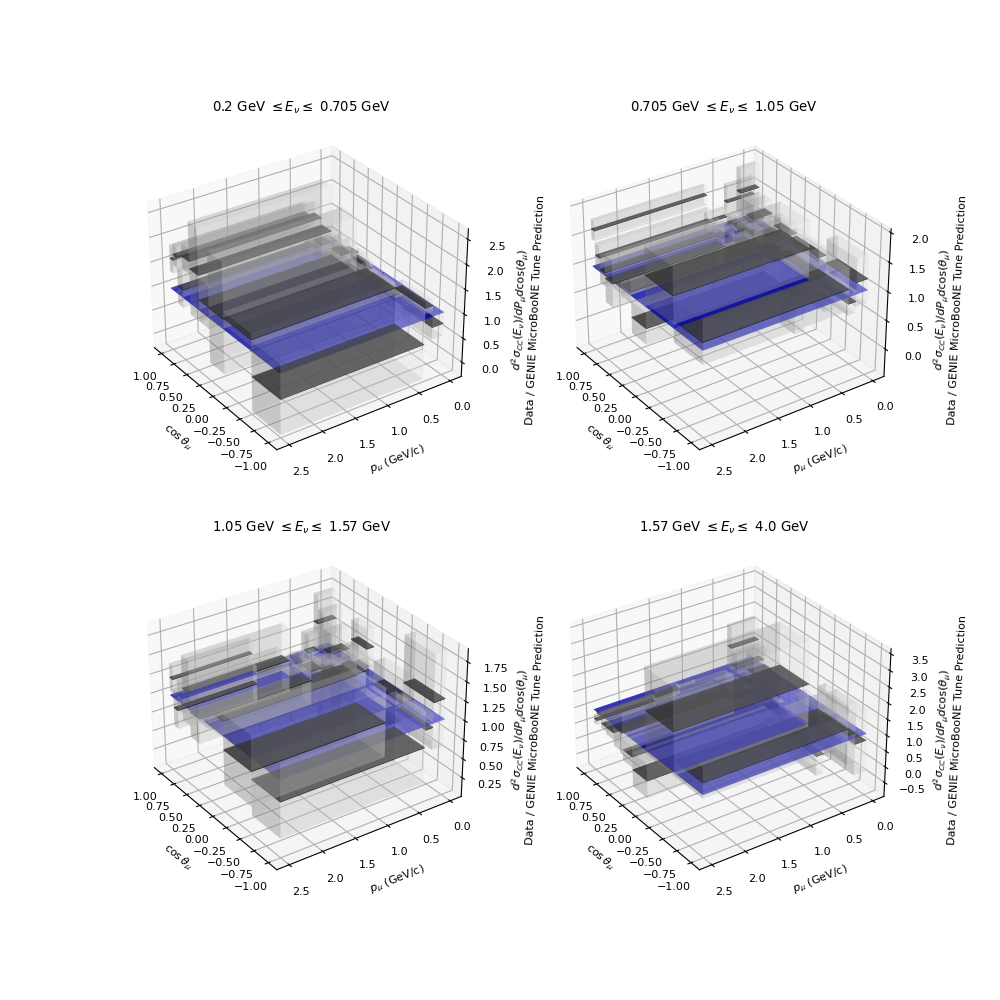

In [14]:
include_mc = False
include_nuwro = False
include_neut = False
include_genie_v3 = False
include_genie_v2 = False


theta = []
mom = []
z = []
dtheta = []
dmom = []
dz = []
z_mc = []
dz_mc = []
z_nuwro = []
dz_nuwro = []
z_neut = []
dz_neut = []
z_genie_v3 = []
dz_genie_v3 = []
z_genie_v2 = []
dz_genie_v2 = []
z_err = []
dz_err = []


for i in range(138):
    
    z_err.append([])
    dz_err.append([])
    
    gap = 0.0001
    
    for k in range(9):
        if angle_bin_strs[i] == f"theta{k}":
            theta.append(angle_bin_edges[k])
            dtheta.append(angle_bin_edges[k+1] - angle_bin_edges[k] - gap)
    
    mom.append(momentum_bin_lower_edges[i])
    dmom.append(momentum_bin_upper_edges[i] - momentum_bin_lower_edges[i] - gap)
    
    
    # this section includes all blocks that will be plotted, including data cv, MC predictions, and data errors (possibly split by other predictions)
        
    lower_err = (data_3d[i] - data_3d_err[i]) / mc_3d[i]
    upper_err = (data_3d[i] + data_3d_err[i]) / mc_3d[i]
    
    thickness = min(0.01, (upper_err - lower_err) / 4.)
    
    z.append(data_3d[i] / mc_3d[i] - thickness / 2.)
    dz.append(thickness - gap)
    
    z_mc.append(mc_3d[i] - thickness / 2.)
    dz_mc.append(thickness - gap)
    
    z_nuwro.append(nuwro_3d[i] - thickness / 2.)
    dz_nuwro.append(thickness - gap)
    
    z_neut.append(neut_3d[i] - thickness / 2.)
    dz_neut.append(thickness - gap)

    z_genie_v3.append(genie_v3_3d[i] - thickness / 2.)
    dz_genie_v3.append(thickness - gap)
 
    z_genie_v2.append(genie_v2_3d[i] - thickness / 2.)
    dz_genie_v2.append(thickness - gap)
    
    interrupting_vals = []
    interrupting_vals.append(data_3d[i] / mc_3d[i])
    if include_mc:
        interrupting_vals.append(mc_3d[i])
    if include_nuwro:
        interrupting_vals.append(nuwro_3d[i])
    if include_neut:
        interrupting_vals.append(neut_3d[i])
    if include_genie_v3:
        interrupting_vals.append(genie_v3_3d[i])
    if include_genie_v2:
        interrupting_vals.append(genie_v2_3d[i])
    
    interrupting_vals.sort()
    
    z_err_edges = []
    z_err_edges.append(lower_err)
    for v in interrupting_vals:
        if lower_err < v < upper_err:
            z_err_edges.append(v)
    z_err_edges.append(upper_err)
    
    fixed_z_err_edges = [z_err_edges[0]]
        
    for k in range(len(z_err_edges) - 1):
                
        if k == 0 or k == len(z_err_edges) - 2:
            width = z_err_edges[k+1] - z_err_edges[k] - thickness / 2. - gap
        else:
            width = z_err_edges[k+1] - z_err_edges[k] - thickness - gap

        if width > 0:
            if z_err_edges[k] in interrupting_vals:
                z_err[-1].append(z_err_edges[k] + thickness / 2.)
            else:
                z_err[-1].append(z_err_edges[k])
            dz_err[-1].append(width)
            fixed_z_err_edges.append(z_err_edges[k+1])
            
            
    if i == -1:
        print("data with err", data_3d[i] - data_3d_err[i], data_3d[i], data_3d[i] + data_3d_err[i])
        print("mc pred", mc_3d[i])
        print("interrupting vals", interrupting_vals)
        print("z edges with small sections removed", fixed_z_err_edges)
        print("all z bases", z_err[-1])
        print("all z widths", dz_err[-1])


mpl.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(10,10))
    
for e_i in [0, 1, 2, 3]:
    if e_i == 0:
        low = 0
        high = 28
        title = r"0.2 GeV $\leq E_\nu \leq$ 0.705 GeV"
    elif e_i == 1:
        low = 28
        high = 63
        title = r"0.705 GeV $\leq E_\nu \leq$ 1.05 GeV"
    elif e_i == 2:
        low = 63
        high = 105
        title = r"1.05 GeV $\leq E_\nu \leq$ 1.57 GeV"
    elif e_i == 3:
        low = 105
        high = 138
        title = r"1.57 GeV $\leq E_\nu \leq$ 4.0 GeV"
    
    theta_e = theta[low:high]
    dtheta_e = dtheta[low:high]
    mom_e = mom[low:high]
    dmom_e = dmom[low:high]
    z_e = z[low:high]
    dz_e = dz[low:high]
    z_err_e = z_err[low:high]
    dz_err_e = dz_err[low:high]
    
    z_mc_e = z_mc[low:high]
    dz_mc_e = dz_mc[low:high]
    z_nuwro_e = z_nuwro[low:high]
    dz_nuwro_e = dz_nuwro[low:high]
    z_neut_e = z_neut[low:high]
    dz_neut_e = dz_neut[low:high]
    z_genie_v3_e = z_genie_v3[low:high]
    dz_genie_v3_e = dz_genie_v3[low:high]
    z_genie_v2_e = z_genie_v2[low:high]
    dz_genie_v2_e = dz_genie_v2[low:high]
    
    
    
    ax = fig.add_subplot(2, 2, e_i+1, projection='3d')
    
    if backwards:
        x1, y1, z1 = 2.5, -1., 10.
    else:
        ax.view_init(elev=30., azim=145.)
        x1, y1, z1 = -1., 2.5, 10.
    
    z_supression = 1e-8 # make the z position have less priority than x and y positions for occlusion
    distances_xy = []
    for i in range(len(theta_e)):
        distances_xy.append(-np.sqrt((theta_e[i] - x1)**2 + (mom_e[i] - y1)**2))
            
    for i in range(len(theta_e)):
        
        #print(e_i, i, z_e[i])
        
        #if e_i == 3 and i == 0:
        #    print(e_i, i, z_e[i], mom_e[i], dmom_e[i], theta_e[i], dtheta_e[i])
        
        # plotting data CV
        pl = ax.bar3d(theta_e[i], mom_e[i], z_e[i], dtheta_e[i], dmom_e[i], dz_e[i], color="k", alpha=0.5)
        pl._sort_zpos = distances_xy[i] + 1e-4 * z_e[i] # z distance is last priority
        
        pl = ax.bar3d(theta_e[i], mom_e[i], 1. - thickness / 2., dtheta_e[i], dmom_e[i], thickness, color="b", alpha=0.5)
        pl._sort_zpos = distances_xy[i] + 1e-4 * z_mc_e[i]
            
        # plotting data error
        for k in range(len(z_err_e[i])):
            pl = ax.bar3d(theta_e[i], mom_e[i], z_err_e[i][k], dtheta_e[i], dmom_e[i], dz_err_e[i][k], color="w", alpha=0.2)
            pl._sort_zpos = distances_xy[i] + 1e-4 * z_err_e[i][k]

    #ax.bar3d(theta_e, mom_e, z_err_bottom_e, dtheta_e, dmom_e, dz_err_bottom_e, zorder=1, alpha=err_alpha, color=err_color)
    #ax.bar3d(theta_e, mom_e, z_err_top_e, dtheta_e, dmom_e, dz_err_top_e, zorder=3, alpha=err_alpha, color=err_color)


    #ax.bar3d(theta_e, mom_e, z_err_bottom_e, dtheta_e, dmom_e, dz_err_bottom_e, zorder=zorders, alpha=err_alpha, color=err_color)
    #ax.bar3d(theta_e, mom_e, z_err_top_e, dtheta_e, dmom_e, dz_err_top_e, zorder=zorders, alpha=err_alpha, color=err_color)

    plt.title(title)

    ax.set_xlabel(r'$\cos \theta_\mu$')
    ax.set_ylabel(r'$p_\mu$ (GeV/c)')
    ax.set_zlabel(r'$d^2\sigma_{CC}(E_\nu)/dP_\mu d\cos(\theta_\mu)$'"\nData / GENIE MicroBooNE Tune Prediction")

plt.show()

if backwards:
    plt.savefig("plots/data_ratio_backwards.png", dpi=600)
else:
    plt.savefig("plots/data_ratio.png", dpi=600)
    

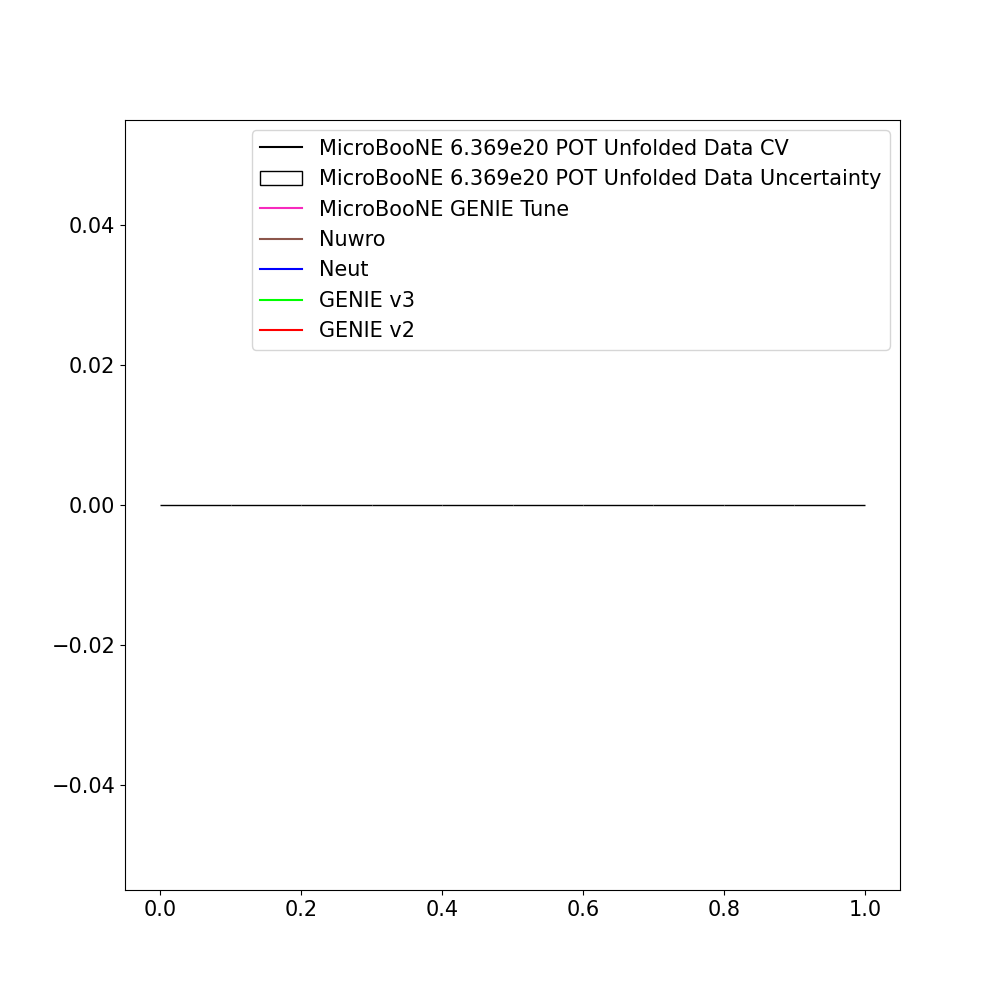

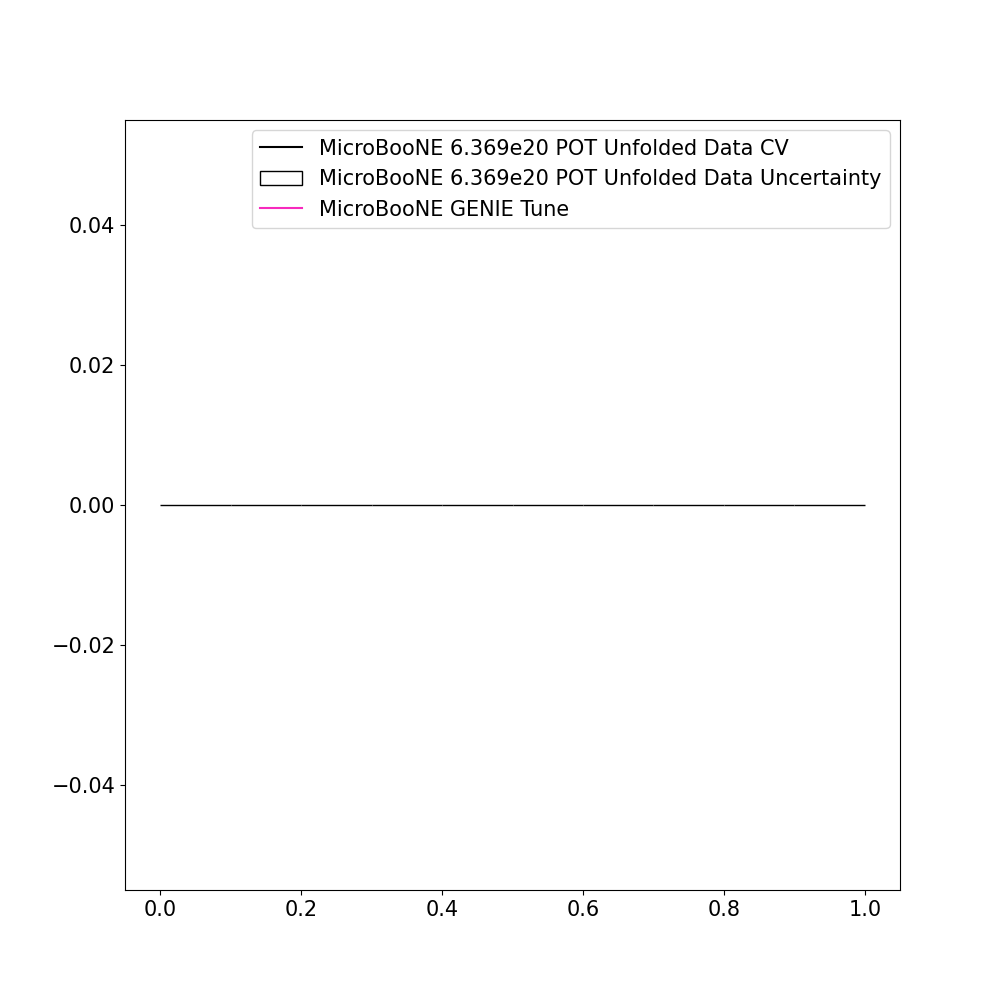

In [15]:
# getting a legend only
mpl.rcParams.update({'font.size': 15})

plt.figure(figsize=(10,10))
plt.plot([], [], color="k", label="MicroBooNE 6.369e20 POT Unfolded Data CV")
plt.hist([], color="w", label="MicroBooNE 6.369e20 POT Unfolded Data Uncertainty", edgecolor = "black")
plt.plot([], [], color="#f72abd", label="MicroBooNE GENIE Tune")
plt.plot([], [], color="tab:brown", label="Nuwro")
plt.plot([], [], color="b", label="Neut")
plt.plot([], [], color="lime", label="GENIE v3")
plt.plot([], [], color="red", label="GENIE v2")

plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot([], [], color="k", label="MicroBooNE 6.369e20 POT Unfolded Data CV")
plt.hist([], color="w", label="MicroBooNE 6.369e20 POT Unfolded Data Uncertainty", edgecolor = "black")
plt.plot([], [], color="#f72abd", label="MicroBooNE GENIE Tune")

plt.legend()
plt.show()

In [16]:
"""theta = []
mom = []
z = []
dtheta = []
dmom = []
dz = []

for i in range(138):
    
    for k in range(9):
        #print(
        if angle_bin_strs[i] == f"theta{k}":
            theta.append(angle_bin_edges[k])
            dtheta.append(angle_bin_edges[k+1] - angle_bin_edges[k])
        
    mom.append(momentum_bin_lower_edges[i])
    dmom.append(momentum_bin_upper_edges[i] - momentum_bin_lower_edges[i])
    
    z.append(data_3d[i] - 0.0001)
    dz.append(0.0001)

fig = plt.figure(figsize=(12,12))
    
for e_i in [0, 1, 2, 3]:
    if e_i == 0:
        theta_e = theta[:29]
        dtheta_e = dtheta[:29]
        mom_e = mom[:29]
        dmom_e = dmom[:29]
        z_e = z[:29]
        dz_e = dz[:29]
        title = r"0.2 GeV $\leq E_\nu \leq$ 0.705 GeV"
    elif e_i == 1:
        theta_e = theta[29:64]
        dtheta_e = dtheta[29:64]
        mom_e = mom[29:64]
        dmom_e = dmom[29:64]
        z_e = z[29:64]
        dz_e = dz[29:64]
        title = r"0.705 GeV $\leq E_\nu \leq$ 1.05 GeV"
    elif e_i == 2:
        theta_e = theta[64:106]
        dtheta_e = dtheta[64:106]
        mom_e = mom[64:106]
        dmom_e = dmom[64:106]
        z_e = z[64:106]
        dz_e = dz[64:106]
        title = r"1.05 GeV $\leq E_\nu \leq$ 1.57 GeV"
    elif e_i == 3:
        theta_e = theta[106:139]
        dtheta_e = dtheta[106:139]
        mom_e = mom[106:139]
        dmom_e = dmom[106:139]
        z_e = z[106:139]
        dz_e = dz[106:139]
        title = r"1.57 GeV $\leq E_\nu \leq$ 4.0 GeV"
        
    mpl.rcParams.update({'font.size': 10})
    
    ax = fig.add_subplot(2, 2, e_i+1, projection='3d')
    ax.bar3d(theta_e, mom_e, z_e, dtheta_e, dmom_e, dz_e)
    ax.view_init(elev=30., azim=145.)
    plt.title(title)

    ax.set_xlabel(r'$\cos \theta_\mu$')
    ax.set_ylabel(r'$p_\mu$ (GeV/c)')
    ax.set_zlabel(r'$d^2\sigma_{CC}(E_\nu)/dP_\mu d\cos(\theta_\mu)$ ($10^{-36}$ cm$^2$ / GeV$^2$ / Ar)')

plt.show()"""
pass


In [17]:
"""theta = []
mom = []
z = []
dtheta = []
dmom = []
dz = []

for i in range(138):
    
    for k in range(9):
        #print(
        if angle_bin_strs[i] == f"theta{k}":
            theta.append(angle_bin_edges[k])
            dtheta.append(angle_bin_edges[k+1] - angle_bin_edges[k])
        
    mom.append(momentum_bin_lower_edges[i])
    dmom.append(momentum_bin_upper_edges[i] - momentum_bin_lower_edges[i])
    
    z.append(0.)
    dz.append(data_3d[i])

fig = plt.figure(figsize=(12,12))
    
for e_i in [0, 1, 2, 3]:
    if e_i == 0:
        theta_e = theta[:29]
        dtheta_e = dtheta[:29]
        mom_e = mom[:29]
        dmom_e = dmom[:29]
        z_e = z[:29]
        dz_e = dz[:29]
        title = r"0.2 GeV $\leq E_\nu \leq$ 0.705 GeV"
    elif e_i == 1:
        theta_e = theta[29:64]
        dtheta_e = dtheta[29:64]
        mom_e = mom[29:64]
        dmom_e = dmom[29:64]
        z_e = z[29:64]
        dz_e = dz[29:64]
        title = r"0.705 GeV $\leq E_\nu \leq$ 1.05 GeV"
    elif e_i == 2:
        theta_e = theta[64:106]
        dtheta_e = dtheta[64:106]
        mom_e = mom[64:106]
        dmom_e = dmom[64:106]
        z_e = z[64:106]
        dz_e = dz[64:106]
        title = r"1.05 GeV $\leq E_\nu \leq$ 1.57 GeV"
    elif e_i == 3:
        theta_e = theta[106:139]
        dtheta_e = dtheta[106:139]
        mom_e = mom[106:139]
        dmom_e = dmom[106:139]
        z_e = z[106:139]
        dz_e = dz[106:139]
        title = r"1.57 GeV $\leq E_\nu \leq$ 4.0 GeV"
        
    mpl.rcParams.update({'font.size': 10})
    
    ax = fig.add_subplot(2, 2, e_i+1, projection='3d')
    ax.bar3d(theta_e, mom_e, z_e, dtheta_e, dmom_e, dz_e, alpha=0.3)
    ax.view_init(elev=30., azim=145.)
    plt.title(title)

    ax.set_xlabel(r'$\cos \theta_\mu$')
    ax.set_ylabel(r'$p_\mu$ (GeV/c)')
    ax.set_zlabel(r'$d^2\sigma_{CC}(E_\nu)/dP_\mu d\cos(\theta_\mu)$ ($10^{-36}$ cm$^2$ / GeV$^2$ / Ar)')

plt.show()"""
pass
